In [12]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

# thresh = 0.15

def get_lscale(y,Lvv):
    Ny = np.size(Lvv)
    i1 = np.argmin(abs(Lvv[:Ny/2]-thresh))
    i2 = np.argmin(abs(Lvv[Ny/2:]-thresh)) + Ny/2 
    L_int = abs(y[i1]-y[i2])
    return L_int

# Thickness and growth rates
def get_dtheta(directory,time):
    filename_prefix = directory+'/shearlayer_'
    tlist,dtheta,rate = growth_rates(filename_prefix)
    idx = np.argmin(abs(tlist-time))
    return dtheta[idx]

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    rate = dat[:,2]
    return time,dtheta,rate

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

# get centerline from Reynolds stresses (vector)
def get_centerline(directory,y,tID):
    nmodes = 10
    dat = np.fromfile( directory + 'shearlayer_Rij_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats]) 
    yc = 0
    for i in [0,1]:
        ic = np.argmax(smooth_modes(abs(dat[:,i]),nmodes))
        yc += y[ic]
    yc /= 2.    
    ic = np.argmin(abs(y-yc))
    return ic,y[ic]

def smooth_modes(f,nmodes):
    fhat = np.fft.fft(f)
    fhat[nmodes+1:-(nmodes+1):] = 0
    f = np.fft.ifft(fhat)
    return f


In [3]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024.0x1448.0x512.0
	L = 80.0x80.0x40.0
['shearlayer_lscale_vv_0004.dat', 'shearlayer_lscale_vv_0005.dat', 'shearlayer_lscale_vv_0006.dat', 'shearlayer_lscale_vv_0007.dat', 'shearlayer_lscale_vv_0008.dat', 'shearlayer_lscale_vv_0009.dat']


-3.178991015894951
-3.8977194194885953
-3.842432619212161
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/
Mean, std: [0.77770274533, 0.0]


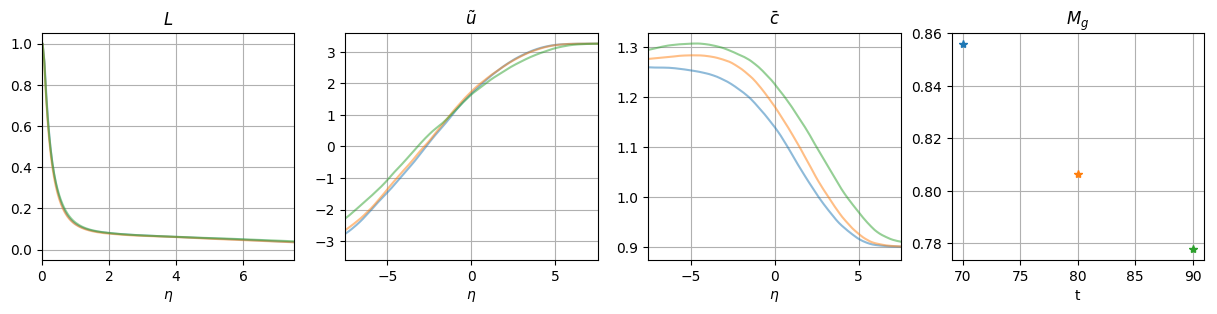

In [16]:
# vv correlation profiles
fig,ax = plt.subplots(1,4,figsize=(15,3), dpi=100)

flist_plot = flist[3:]
Mgs = np.zeros(len(flist_plot))
alpha = 0.5

for count,fname in zip(range(len(flist_plot)),flist_plot):
    tID = fname.split('_')[-1]
    tID = int(tID.split('.dat')[0])
    time = nml.read_time(directory,tID)
    
    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta
    
    # Get centerline
    ic,yc = get_centerline(directory,y,tID)
    print(yc)
    
    # Get integral lengthscale
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    dat = np.fft.fftshift(dat)
    L_int = get_lscale(y,dat)
    ax[0].plot(eta, dat, alpha=alpha,label='t=%d'%time)
    
    # Get shear S
    utilde = np.fromfile( directory + 'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
    offset = 2
    i1 = ic-offset
    i2 = ic+offset
    dy = y[i1]-y[i2]
    S = (utilde[i1]-utilde[i2])/dy   
    ax[1].plot(eta, utilde, alpha=alpha)
    
    # Get cbar
    cbar = np.fromfile( directory + 'shearlayer_cbar_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
    ax[2].plot(eta, cbar, alpha=alpha)

    # Record for later
    Mgs[count] = S*L_int/cbar[ic]
    ax[3].plot(time, Mgs[count],'*')

# Clean up plot
xmax = L_int*4
ax[0].set_xlim([0.,xmax])
ax[1].set_xlim([-xmax,xmax])
ax[2].set_xlim([-xmax,xmax])
ax[0].set_title(r'$L$')
ax[1].set_title(r'$\tilde{u}$')
ax[2].set_title(r'$\bar{c}$')
ax[3].set_title(r'$M_g$')
for a in ax:
    a.grid(True)
    a.set_xlabel(r'$\eta$')
ax[3].set_xlabel('t')
    
    
# Where to start stats:
i = -1
print(directory)
print("Mean, std: [{}, {}]".format(np.mean(Mgs[i:]),np.std(Mgs[i:])))

plt.savefig(directory+'/img/Mg.png',dpi=200, bbox_inches='tight')

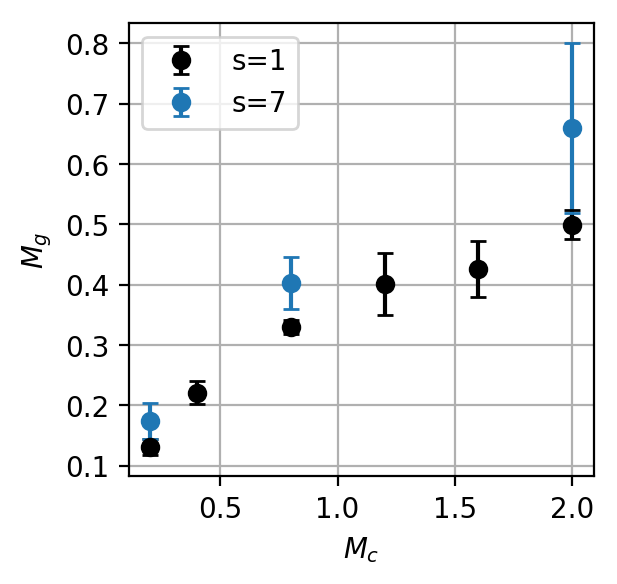

In [9]:
# PadeOps
fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)

Mg = {
    0.2: [0.130436687026, 0.0130058738824],
    0.4: [0.220549356693, 0.0192357782093],
    0.8: [0.330251214502, 0.0113992419973],
    1.2: [0.401280304809, 0.0508855572847],
    1.6: [0.425876374613, 0.0456586507061],
    2.0: [0.499586892666, 0.0243031664111]}

Mg_rr7 = {
    0.2: [0.165302716754, 0.0144092264261],
    0.8: [0.416236223849, 0.0103215363705],
    2.0: [0.713714293268, 0.0398649019376]}

Mg_rr_7 = {
    0.2: [0.183555990595, 0.0146477831479],
    0.8: [0.389142917011, 0.0280491555446],
    2.0: [0.605482964969, 0.0766708091348]}

Mg_Freund = {
0.0996234234593239: 0.29936838749526773,
0.1992468469186476: 0.5987118691346711,
0.4087349817689136: 1.2046713423260078,
0.5934965829165755: 1.4890837633744445,
0.8023072784873182: 1.8465077008906334,
0.9896790133296143: 1.8385129211580227,
1.2826515770387936: 1.8228222319631793,
1.5423897666819428: 2.114270557293431,
1.8011317220904983: 2.0402254478072885
}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5 + np.std([v1,v2])
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(Mg_rr7,Mg_rr_7)

plt.errorbar(Mg.keys(),[x[0] for x in Mg.values()], yerr=[x[1] for x in Mg.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k+0.02 for k in Mg_rr7.keys()],[x[0] for x in Mg_rr7.values()], yerr=[x[1] for x in Mg_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k-0.02 for k in Mg_rr_7.keys()],[x[0] for x in Mg_rr_7.values()], yerr=[x[1] for x in Mg_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
# plt.plot(Mg_Freund.keys(),Mg_Freund.values(),'o',label='Freund 2000')
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)

plt.legend()
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$M_g$')
# plt.ylim([0,0.4])
plt.savefig('/home/kmatsuno/ShearLayer_img/Mg.png',dpi=200, bbox_inches='tight')

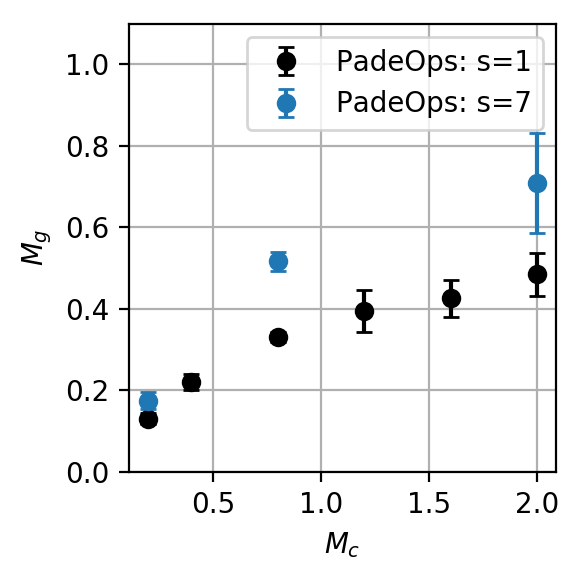

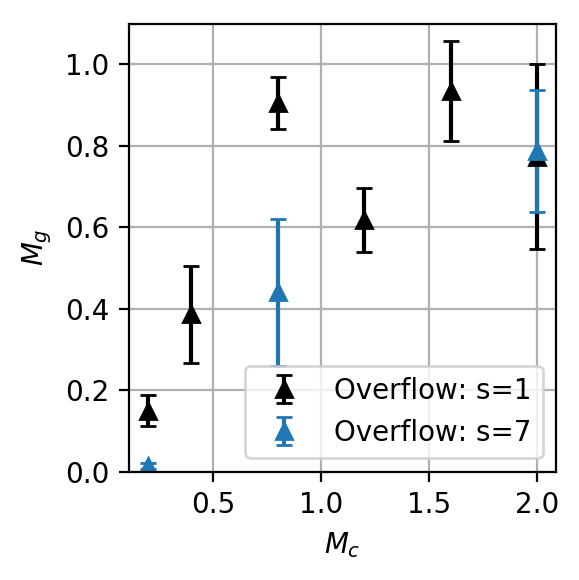

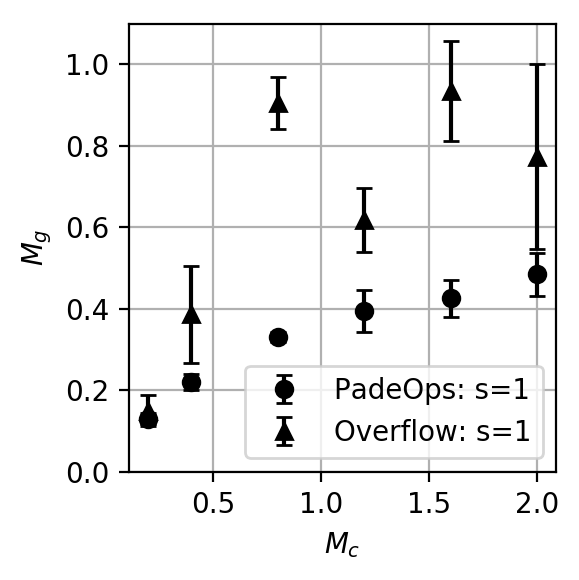

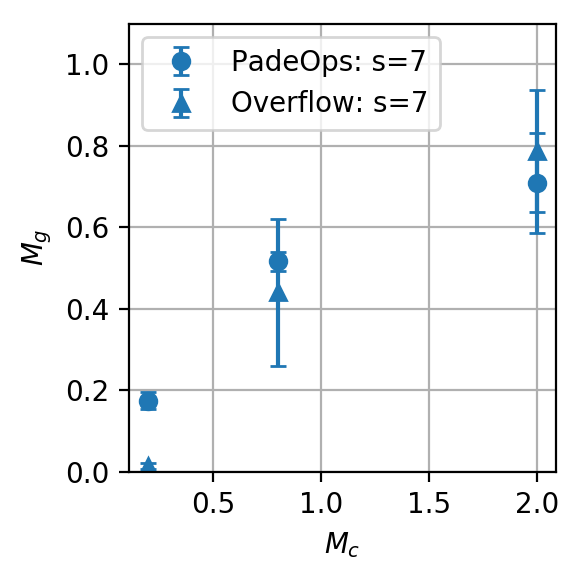

In [62]:
#OVERFLOW: 

Mg_ovf = {
    0.2: [0.149, 0.038],
    0.4: [0.386, 0.119],
    0.8: [0.905, 0.064],
    1.2: [0.617, 0.078],
    1.6: [0.935, 0.123],
    2.0: [0.773, 0.227] }
Mg_rr_7_ovf = {
    0.2: [0.011, 0.003],
    0.8: [0.531, 0.155],
    2.0: [0.959, 0.129]}
Mg_rr7_ovf = {
    0.2: [0.017, 0.007],
    0.8: [0.349, 0.093],
    2.0: [0.613, 0.076]}

DPI=200 
def make_nice():
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$M_c$')
    plt.ylabel(r'$M_g$')
    plt.ylim([0,1.1])
    plt.tight_layout()
    
Lvv = Mg
Lvv_rr_7 = Mg_rr_7
Lvv_rr7 = Mg_rr7
Lvv_ovf = Mg_ovf
Lvv_rr_7_ovf = Mg_rr_7_ovf
Lvv_rr7_ovf = Mg_rr7_ovf

rr_ovf = merge_dicts(Lvv_rr7_ovf,Lvv_rr_7_ovf)

DPI=200 
prefix = '/home/kmatsuno/Ovf_compare/Mg_'

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7.keys(),[x[0] for x in Lvv_rr_7.values()],yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='PadeOps: s=1/7',color='C0',capsize=3)
# plt.errorbar(Lvv_rr7.keys(),[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='PadeOps: s=7',color='C1',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7_ovf.keys(),[x[0] for x in Lvv_rr_7_ovf.values()], yerr=[x[1] for x in Lvv_rr_7_ovf.values()],fmt='^',color='C0',label='Overflow: s=1/7',capsize=3)
# plt.errorbar(Lvv_rr7_ovf.keys(),[x[0] for x in Lvv_rr7_ovf.values()], yerr=[x[1] for x in Lvv_rr7_ovf.values()],fmt='^',color='C1',label='Overflow: s=7',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
make_nice()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()],yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',color='C0',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C0',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')
